# Decoding and postprocess
### The last two cells are implementable, respectively for decoding and show the received image and calculating PSNR.
### Make sure the received file is named 'test_test.bnr.gz' then just run the former implementable cell. For the later cell, make sure before running it, the image read in is the orginal image of what we are testing.

In [58]:
import numpy as np
import math
import array
import bitarray
from bitarray import bitarray
from array import *
from array import array
import cv2
from numpy import *
from math import *
import array
from array import array
import scipy
from scipy import signal
from numpy.fft import *
import gzip
import matplotlib.pyplot as plt

In [2]:
def dec2binstr(number,digit=4):
    return str(bin(number))[2:].zfill(digit)

In [3]:
def binstr2dec2(arr,digit=6):
    if arr=='0': return 0
    else: 
        return (int(arr,2)-32-5)

In [4]:
def dezigzag(L):
    #L = np.array([1,4,2,7,5,3,8,6,9])
    #L = np.array([1,5,2,9,6,3,13,10,7,4,14,11,8,15,12,16])
    n = np.sqrt(len(L))
    n = int(n)
    a = -1/2
    b = 2*n-1/2
    c = n-n*n
    
    M = []
    for i in range(1,n+1):
        for j in range(1,n+1):
            p = i+j-2
            if p <= n:
                q = 1/2*p*p+1/2*p
            else:
                q = a*p*p+b*p+c
            q = int(q)
            M.append(L[q+j-1-max(0,i+j-1-n)])
            j = j+1
        i = i+1
    
    M_old = np.reshape(M,(n,n))
    return M_old

In [5]:
def dequantize2(maxi,lv):
    p_lv=26
    n_lv=15
    if lv>0:
        return (lv-0.5)/p_lv*maxi
    else:
        if lv<=0:
            return (lv-0.5)/n_lv*maxi

In [6]:
def readfrombnr(filename):
    with open(filename,"rb") as f:
        block = f.read()
        string = []
        for i in range(0,len(block)):
            string.append(dec2binstr(block[i],8))
            i = i+1
    f.close()
    string = "".join(string)
    return string

In [7]:
def readfromgzip(fname):
    with gzip.open(fname, 'rb') as f:
        file_content = f.read()
    f.close()
    string = []
    for i in range(0,len(file_content)):
        string.append(dec2binstr(file_content[i],8))
        i = i+1
    string = "".join(string)
    return string

In [8]:
def postprocess(img):
    img=img*255
    img=uint8(img)
    med=scipy.signal.medfilt2d(img,7)

    #Gussian Lowpass Filter
    freq=fftshift(fft2(med))
    fsz=freq.shape
    filt=zeros([fsz[0],fsz[1]])

    D=60
    for i in range(0,fsz[0]):
        for j in range(0,fsz[1]):
            filt[i,j]=exp(-(pow((i-fsz[0]//2),2)+pow(j-fsz[1]//2,2))/(2*pow(D,2)))

    freq2=multiply(freq,filt)
    img2=ifft2(freq2)

    #Iterative deconvolution
    temp=uint8(abs(img2))
    img2=scipy.signal.wiener(float64(temp))
    return uint8(abs(img2))

In [9]:
def upsample(img,ox,oy):
    img_f=fftshift(fft2(img))
    #print('original shape is',ox,oy)
    x,y=img_f.shape
    #print('shape now is',x,y)
    #print(ox-(ox-x)//2)
    if(ox<=x)or(oy<=y):
        return img[0:ox,0:oy]
    else:
        img_f=pad(img_f,(((ox-x)//2,ox-x-(ox-x)//2),((oy-y)//2,oy-y-(oy-y)//2)),'constant')
        #print('shape of FFT after extension is',img_f.shape)
        op=ifft2(ifftshift(img_f))
        #print('shape of iFFT is',op.shape)
        op=op/op.max()*255
        return uint8(abs(op))

In [10]:
def EE123_psnr(ref, meas, maxVal=255):
    assert np.shape(ref) == np.shape(meas), "Test image must match measured image dimensions"
        
    
    dif = (ref.astype(float)-meas.astype(float)).ravel()
    mse = np.linalg.norm(dif)**2/np.prod(np.shape(ref))
    psnr = 10*np.log10(maxVal**2.0/mse)
    return psnr

In [43]:
def decode(stri):
    winsz=8
    winnum=0
    coefn=0
    arr=[]
    ox=int(stri[0:11],2)
    oy=int(stri[11:22],2)
    height=int(stri[22:33],2)
    width=int(stri[33:44],2)
    print(height)
    print(width)
    
    imgR=zeros([height,width])
    imgG=zeros([height,width])
    imgB=zeros([height,width])
    imgR_idct=zeros([height,width])
    imgG_idct=zeros([height,width])
    imgB_idct=zeros([height,width])
    
    s_x=int(height/8)
    s_y=int(width/8)
    
    maxR=int(stri[44:57],2)/1000
    print(maxR)
    index=57
    s=0
    while winnum<s_x*s_y:
        if stri[index]=='0':
            for i in range(0, 64-coefn):
                arr.append('0')
            win=dezigzag(arr)
            x_index=int(winnum//s_y)
            y_index=int(winnum-x_index*s_y)
            imgR[x_index*8:(x_index+1)*8,y_index*8:(y_index+1)*8]=win
            winnum+=1
            arr=[]
            s+=coefn
            coefn=0
            index+=1
        else:
            cod=stri[index:index+6]
            num=binstr2dec2(cod)
            num=dequantize2(maxR,num)
            arr.append(num)
            index+=6
            coefn+=1
    print(s)
    maxG=int(stri[index:index+13],2)/1000
    print(maxG)
    index+=13
    winnum=0
    while winnum<s_x*s_y:
        if stri[index]=='0':
            for i in range(0, 64-coefn):
                arr.append('0')
            win=dezigzag(arr)
            x_index=int(winnum//s_y)
            y_index=int(winnum-x_index*s_y)
            imgG[x_index*8:(x_index+1)*8,y_index*8:(y_index+1)*8]=win
            winnum+=1
            arr=[]
            coefn=0
            index+=1
        else:
            cod=stri[index:index+6]
            num=binstr2dec2(cod)
            num=dequantize2(maxG,num)
            arr.append(num)
            index+=6
            coefn+=1
    
    maxB=int(stri[index:index+13],2)/1000
    print(maxB)
    index+=13
    winnum=0
    while winnum<s_x*s_y:
        if stri[index]=='0':
            for i in range(0, 64-coefn):
                arr.append('0')
            win=dezigzag(arr)
            x_index=int(winnum//s_y)
            y_index=int(winnum-x_index*s_y)
            imgB[x_index*8:(x_index+1)*8,y_index*8:(y_index+1)*8]=win
            winnum+=1
            arr=[]
            coefn=0
            index+=1
        else:
            cod=stri[index:index+6]
            num=binstr2dec2(cod)
            num=dequantize2(maxB,num)
            arr.append(num)
            index+=6
            coefn+=1
    
    print(len(stri)-index)
    for i in range(0,s_x):
        for j in range(0,s_y):
            imgR_idct[i*winsz:(i+1)*winsz,j*winsz:(j+1)*winsz]=cv2.idct(imgR[i*winsz:(i+1)*winsz,j*winsz:(j+1)*winsz])
            imgG_idct[i*winsz:(i+1)*winsz,j*winsz:(j+1)*winsz]=cv2.idct(imgG[i*winsz:(i+1)*winsz,j*winsz:(j+1)*winsz])
            imgB_idct[i*winsz:(i+1)*winsz,j*winsz:(j+1)*winsz]=cv2.idct(imgB[i*winsz:(i+1)*winsz,j*winsz:(j+1)*winsz])
    #imgR_idct=uint8(abs(imgR_idct/imgR_idct.max()*255))
    #imgG_idct=uint8(abs(imgG_idct/imgG_idct.max()*255))
    #imgB_idct=uint8(abs(imgB_idct/imgB_idct.max()*255))
    
    imgR_idct=postprocess(imgR_idct)
    imgG_idct=postprocess(imgG_idct)
    imgB_idct=postprocess(imgB_idct)
    
    imgR_idct=upsample(imgR_idct,ox,oy)
    imgG_idct=upsample(imgG_idct,ox,oy)
    imgB_idct=upsample(imgB_idct,ox,oy)
    
    img2=zeros([ox,oy,3])
    img2[:,:,0]=imgR_idct
    img2[:,:,1]=imgG_idct
    img2[:,:,2]=imgB_idct

    return img2

176
384
7.987
4241
7.996
8.0
5


C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:950: RuntimeWarning: divide by zero encountered in true_divide
  res *= (1 - noise / lVar)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:950: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)


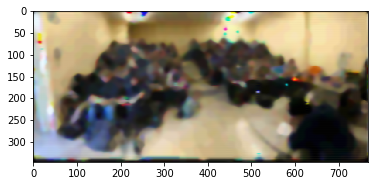

In [56]:
# The former implemetable cell
# Decoding the messages received and return an image
message=readfromgzip("test.bnr.gz")
img=decode(message)
pltimg=plt.imshow(cv2.cvtColor(uint8(img), cv2.COLOR_BGR2RGB))
plt.show()

In [57]:
# The latter implementable cell
# Calculation of PSNR
o_img=cv2.imread('mid_test.tiff',1)

EE123_psnr(o_img,uint8(img))

17.252521892492325